### Analysis of White masks in the steel sheets

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch
import shap
import warnings

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

from tqdm import tqdm
from torchvision import models
from torch import nn
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc

### Load data

In [2]:
n_classes = 2
class_labels = {0: 'No Defects', 1: 'Defects'}
params = c_utils.get_default_params()
device = torch.device('cuda')
#warnings.filterwarnings("ignore")

In [3]:
MODEL_PATH = '../model/OfficialBinaryModels/AugmentedSqueezeReduced10.pth'

IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/binaryData'
METADATA_PATH = '../data/binaryData/test_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_test_binary.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_test_binary.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_test_binary.pth'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


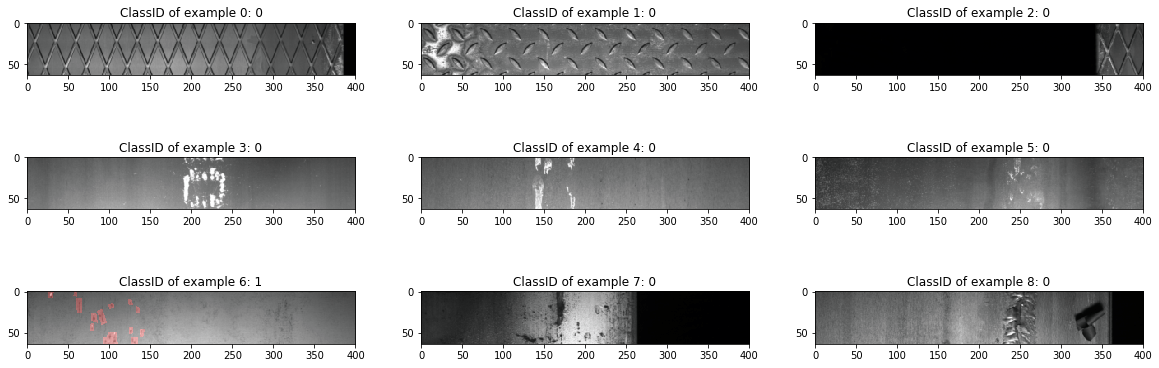

In [4]:
X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)

fig, ax = plt.subplots(3, 3, figsize=(20, 7))
start = 0
for i in range(start, start+9):
    img = np.transpose(X_val[i].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_val[i].reshape(*params['size'])
    img[mask == 1] = img[mask == 1] + params['colors'][y_val[i]]
    ax[(i-start)//3, (i-start)%3].set_title('ClassID of example {}: {}'.format(i, y_val[i]))
    ax[(i-start)//3, (i-start)%3].imshow(img)
plt.show()

### Model

In [5]:
### 4.1 Load architecture
net = models.squeezenet1_1(pretrained=True)
net.features = net.features[:10]
net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, 2))#, nn.Softmax(dim=1))
net = net.to(device)
net.load_state_dict(torch.load(MODEL_PATH))

y_pred, y_true, y_score = [], [], torch.Tensor([])
batch_size = 5

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = net(X)
        probs = out.detach().cpu()
        probs = nn.Softmax(dim=1)(out).detach().cpu()
        
        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])
        
y_score = y_score.numpy()
print('Accuracy: {:.4f}\tF1 Score: {:.4f}'.format(accuracy_score(y_true, y_pred), f1_score(y_true, y_pred)))

100%|████████████████████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 39.87it/s]

Accuracy: 0.9390	F1 Score: 0.9423


### Analysis TSNE

#### 1. Input

In [6]:
tsne_results = []
tsne = TSNE(perplexity=2, n_jobs=-1)
tsne_results.append(tsne.fit_transform(X_val[:-3].numpy().reshape(X_val[:-3].shape[0], -1)))

KeyboardInterrupt: 

In [ ]:
plt.scatter(tsne_results[0][:, 0][y_true == 0], tsne_results[0][:, 1][y_true == 0], alpha=0.45, label='No Defects')
plt.scatter(tsne_results[0][:, 0][y_true == 1], tsne_results[0][:, 1][y_true == 1], alpha=0.30, label='Defects')
plt.legend()
plt.title('T-SNE on the input')
plt.grid()
plt.show()

#### 2. Squeeze Fire layer

In [ ]:
indexes = [3, 4, 6, 7, 9]
for i in indexes:
    tsne_X = torch.Tensor([])
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X = X_val[n*batch_size:(n+1)*batch_size].to(device)
        out = net.features[i].squeeze(net.features[:i](X)).detach().cpu()
        tsne_X = torch.cat([tsne_X, out])
    tsne_X = tsne_X.numpy()
    tsne = TSNE(perplexity=2, n_jobs=-1)
    X_val_tsne = tsne.fit_transform(tsne_X.reshape(tsne_X.shape[0], -1))
    tsne_results.append(X_val_tsne)

#### 3. Last Layer

In [ ]:
tsne_X = torch.Tensor([])
net.eval()
for n in range(X_val.shape[0]//batch_size):
    X = X_val[n*batch_size:(n+1)*batch_size].to(device)
    out = net.classifier[:1](net.features(X)).detach().cpu()
    tsne_X = torch.cat([tsne_X, out])
tsne_X = tsne_X.numpy()
tsne = TSNE(perplexity=2, n_jobs=-1)
X_val_tsne = tsne.fit_transform(tsne_X.reshape(tsne_X.shape[0], -1))
tsne_results.append(X_val_tsne)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
for i in range(6):
    ax[i//3, i%3].scatter(tsne_results[i+1][:, 0][y_true == 0], 
                       tsne_results[i+1][:, 1][y_true == 0], 
                       alpha=0.45, label='No Defects')
    ax[i//3, i%3].scatter(tsne_results[i+1][:, 0][y_true == 1], 
                  tsne_results[i+1][:, 1][y_true == 1], 
                  alpha=0.30, label='Defects')
    ax[i//3, i%3].legend()
    if i < 5:
        ax[i//3, i%3].set_title('T-SNE on the {} squeeze fire layer'.format(i+1))
    else:
         ax[i//3, i%3].set_title('T-SNE on the last layer'.format(i))
    ax[i//3, i%3].grid()
plt.show()

### Maninfold capacity with T-SNE input

In [ ]:
print('Squeeze input: {}'.format(3*64*400))
print('Squeeze 1st Fire: {}'.format(16*15*99))
print('Squeeze 2nd Fire: {}'.format(16*15*99))
print('Squeeze 3rd Fire: {}'.format(32*7*49))
print('Squeeze 4th Fire: {}'.format(32*7*49))
print('Squeeze 5th Fire: {}'.format(48*3*24))

In [ ]:
acc = []
for i in tsne_results:
    clf = LogisticRegression(C=0.1)
    clf.fit(i, y_true)
    acc.append(accuracy_score(clf.predict(i), y_true))
    #print('Accuracy score: {:.4f}'.format(acc[-1]))
reg = LinearRegression()
reg.fit(np.arange(0, 7).reshape(-1, 1), np.array(acc).reshape(-1))
y_pred = reg.predict(np.arange(-0.20, 7.20, step=0.05).reshape(-1, 1))
plt.figure(figsize=(13, 4))
plt.scatter(np.arange(0, 7), acc)
plt.plot(np.arange(-0.20, 7.20, step=0.05), y_pred)
plt.xlim([-0.05, 6.2])
plt.grid()
plt.xticks([i for i in range(7)], ['Input', '1st', '2nd', '3rd', 
           '4th', '5th', 'Last'], rotation = 0)
plt.ylabel('Accuracy of a Logistic Regression')
plt.xlabel('Layer of application of T-SNE')
plt.title('Capacity of Linear separability by each model CNN layer (T-SNE) output', y = 1.01)
plt.show()

### Maninfold capacity with raw input

In [95]:
accs = []

pca =  PCA(0.95)
clf = LogisticRegression(C=1)
scaler = MinMaxScaler()

X = X_val[:-3].numpy().reshape(X_val[:-3].shape[0], -1)
X_train = pca.fit_transform(X[:1000])
X_test = pca.transform(X[1000:])
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf.fit(X_train, y_true[:1000])
accs.append(accuracy_score(clf.predict(X_test), y_true[1000:]))

In [97]:
indexes = [3, 4, 6, 7, 9]
for i in indexes:
    pca_X = torch.Tensor([])
    net.eval()
    for n in range(X_val.shape[0]//batch_size):
        X = X_val[n*batch_size:(n+1)*batch_size].to(device)
        out = net.features[i].squeeze(net.features[:i](X)).detach().cpu()
        pca_X = torch.cat([pca_X, out])
    X = pca_X.numpy().reshape(pca_X.shape[0], -1)
    X_train = pca.fit_transform(X[:1000])
    X_test = pca.transform(X[1000:])
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf.fit(X_train, y_true[:1000])
    accs.append(accuracy_score(clf.predict(X_test), y_true[1000:]))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [98]:
pca_X = torch.Tensor([])
net.eval()
for n in range(X_val.shape[0]//batch_size):
    X = X_val[n*batch_size:(n+1)*batch_size].to(device)
    out = net.classifier[:1](net.features(X)).detach().cpu()
    pca_X = torch.cat([pca_X, out])
X = pca_X.numpy().reshape(pca_X.shape[0], -1)
X_train = pca.fit_transform(X[:1000])
X_test = pca.transform(X[1000:])
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf.fit(X_train, y_true[:1000])
accs.append(accuracy_score(clf.predict(X_test), y_true[1000:]))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


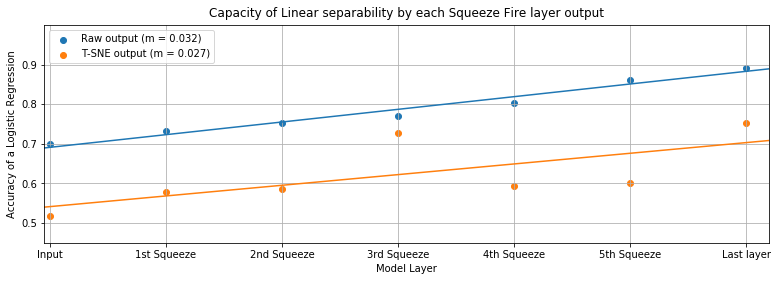

In [116]:
reg = LinearRegression()

reg.fit(np.arange(0, 7).reshape(-1, 1), np.array(accs).reshape(-1))
y_pred = reg.predict(np.arange(-0.20, 7.20, step=0.05).reshape(-1, 1))
plt.figure(figsize=(13, 4))
plt.scatter(np.arange(0, 7), accs, label='Raw output (m = {:.3f})'.format(reg.coef_[0]))
plt.plot(np.arange(-0.20, 7.20, step=0.05), y_pred)

reg.fit(np.arange(0, 7).reshape(-1, 1), np.array(acc).reshape(-1))
y_pred = reg.predict(np.arange(-0.20, 7.20, step=0.05).reshape(-1, 1))
plt.scatter(np.arange(0, 7), acc, label='T-SNE output (m = {:.3f})'.format(reg.coef_[0]))
plt.plot(np.arange(-0.20, 7.20, step=0.05), y_pred)

plt.xlim([-0.05, 6.2])
plt.ylim([0.45, 1])
plt.grid()
plt.xticks([i for i in range(7)], ['Input', '1st Squeeze', '2nd Squeeze', '3rd Squeeze', 
           '4th Squeeze', '5th Squeeze', 'Last layer'], rotation = 0)
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9], [0.5, 0.6, 0.7, 0.8, 0.9])
plt.ylabel('Accuracy of a Logistic Regression')
plt.xlabel('Model Layer')
plt.legend(loc='upper left')
plt.title('Capacity of Linear separability by each Squeeze Fire layer output', y = 1.01)
plt.show()

### Activation functions

In [116]:
modules = [
           list(net.children())[0][0], 
           list(net.children())[0][3].squeeze, list(net.children())[0][3].expand1x1, list(net.children())[0][3].expand3x3,
           list(net.children())[0][4].squeeze, list(net.children())[0][4].expand1x1, list(net.children())[0][4].expand3x3,
           list(net.children())[0][6].squeeze, list(net.children())[0][7].expand1x1, list(net.children())[0][6].expand3x3,
           list(net.children())[0][7].squeeze, list(net.children())[0][7].expand1x1, list(net.children())[0][7].expand3x3,
           list(net.children())[0][9].squeeze, list(net.children())[0][9].expand1x1, list(net.children())[0][9].expand3x3,
           list(net.children())[1][1]
          ]

module_name = ['Conv2d',
               'Squeeze', 'Exp_1x1', 'Exp_3x3',
               'Squeeze', 'Exp_1x1', 'Exp_3x3',
               'Squeeze', 'Exp_1x1', 'Exp_3x3',
               'Squeeze', 'Exp_1x1', 'Exp_3x3',
               'Squeeze', 'Exp_1x1', 'Exp_3x3',
               'Conv2d']

In [55]:
n = 0
means0, means1 = [], []
stds0, stds1 = [], []

for n in tqdm(range(len(modules))):
    hook = c_explainers.SaveFeatures(modules[n])
    output0, output1 = torch.Tensor([]), torch.Tensor([])
    for i in range(30):
        X_0 = X_val[y_val == 0][i*30:(i+1)*30].to(device)
        X_1 = X_val[y_val == 1][i*30:(i+1)*30].to(device)
        ### 2.Compute Loss and gradient
        _ = net(X_0) # Feed the input to the model
        output0 =  torch.cat([output0, hook.features.detach().cpu()])
        _ = net(X_1)
        output1 =  torch.cat([output1, hook.features.detach().cpu()])

    mean0 = output0.mean().numpy()
    mean1 = output1.mean().numpy()
    std0 = output0.mean(axis=(0, 2, 3)).numpy().std(axis=0)
    std1 = output1.mean(axis=(0, 2, 3)).numpy().std(axis=0)
    #means.append(np.mean([mean0, mean1]))
    #stds.append(np.mean([std0, std1]))
    means0.append(mean0)
    stds0.append(std0)
    means1.append(mean1)
    stds1.append(std1)
    
means0, stds0 = np.array(means0), np.array(stds0)
means1, stds1 = np.array(means1), np.array(stds1)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [08:30<00:00, 30.01s/it]


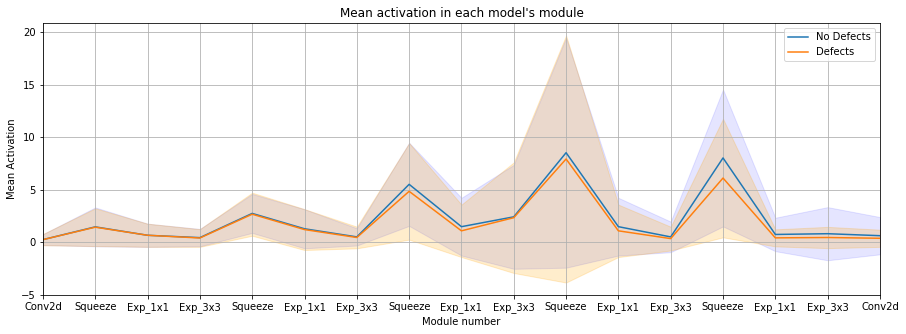

In [118]:
plt.figure(figsize=(15, 5))
plt.grid()

reg = LinearRegression()
reg.fit(np.arange(1, 18).reshape(-1, 1), np.array(means0).reshape(-1))
y_pred = reg.predict(np.arange(0.80, 17.20, step=0.05).reshape(-1, 1))
#plt.plot(np.arange(0.80, 17.20, step=0.05), y_pred, '--', color='black', label='m = {:.3f}'.format(reg.coef_[0]))

plt.plot(np.arange(1, len(means0)+1), means0, label='No Defects')
plt.fill_between(np.arange(1, len(means0)+1), (means0-2*stds0), (means0+2*stds0), color='b', alpha=.1)
plt.plot(np.arange(1, len(means0)+1), means1, label='Defects')
plt.fill_between(np.arange(1, len(means1)+1), (means1-2*stds1), (means1+2*stds1), color='orange', alpha=.2)

plt.ylabel('Mean Activation')
plt.title("Mean activation in each model's module")
plt.xlabel('Module number')
plt.legend()
plt.xticks(np.arange(1, 18), module_name, rotation=0)
plt.xlim([1, 17])
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.grid()


plt.plot(np.arange(1, len(means0)+1), means0, label='No Defects')
plt.fill_between(np.arange(1, len(means0)+1), (means0-2*stds0), (means0+2*stds0), color='b', alpha=.1)
plt.plot(np.arange(1, len(means0)+1), means1, label='Defects')
plt.fill_between(np.arange(1, len(means1)+1), (means1-2*stds1), (means1+2*stds1), color='orange', alpha=.2)

plt.ylabel('Mean Activation')
plt.title("Mean activation in each model's module")
plt.xlabel('Module number')
plt.legend()
plt.xticks(np.arange(1, 18), module_name, rotation=0)
plt.xlim([1, 17])
plt.show()

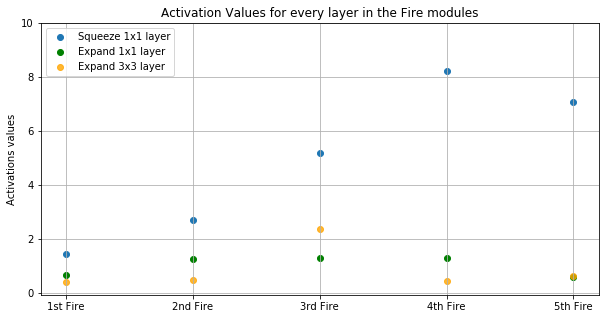

In [134]:
plt.figure(figsize=(10, 5))
mean_a =(means0 + means1)/2
std_a =(stds0 + stds1)/2
ind = [1, 4, 7, 10, 13]
plt.scatter(np.arange(1, len(mean_a[ind])+1), mean_a[ind], label='Squeeze 1x1 layer')
# plt.fill_between(np.arange(1, len(mean_a[ind])+1), 
#                  (mean_a[ind]-2*std_a[ind]), 
#                  (mean_a[ind]+2*std_a[ind]), color='b', alpha=.03)
ind = [2, 5, 8, 11, 14]
plt.scatter(np.arange(1, len(mean_a[ind])+1), mean_a[ind], color='green', label='Expand 1x1 layer')
# plt.fill_between(np.arange(1, len(mean_a[ind])+1), 
#                  (mean_a[ind]-2*std_a[ind]), 
#                  (mean_a[ind]+2*std_a[ind]), color='green', alpha=.1)
ind = [3, 6, 9, 12, 15]
plt.scatter(np.arange(1, len(mean_a[ind])+1), mean_a[ind], color='orange', label='Expand 3x3 layer', alpha=0.8)
# plt.fill_between(np.arange(1, len(mean_a[ind])+1), 
#                  (mean_a[ind]-2*std_a[ind]), 
#                  (mean_a[ind]+2*std_a[ind]), color='orange', alpha=0.1)
plt.grid()
plt.legend(loc='upper left')
plt.xticks([1, 2, 3, 4, 5], ['1st Fire', '2nd Fire', '3rd Fire', '4th Fire', '5th Fire'])
plt.yticks([0, 2, 4, 6, 8, 10])#, 12, 14, 16, 18, 20])
#plt.axhline(0, linestyle='--', color='black', linewidth=2)
plt.xlim([0.8, 5.2])
plt.ylabel('Activations values')
plt.title('Activation Values for every layer in the Fire modules')
plt.show()





### Weights

In [45]:
n = 0
means, stds = [], []

for mod in modules:
    mean = mod.weight.mean().detach().cpu().numpy()
    std = mod.weight.std().detach().cpu().numpy()
    means.append(mean)
    stds.append(std)
    
means, stds = np.array(means), np.array(stds)

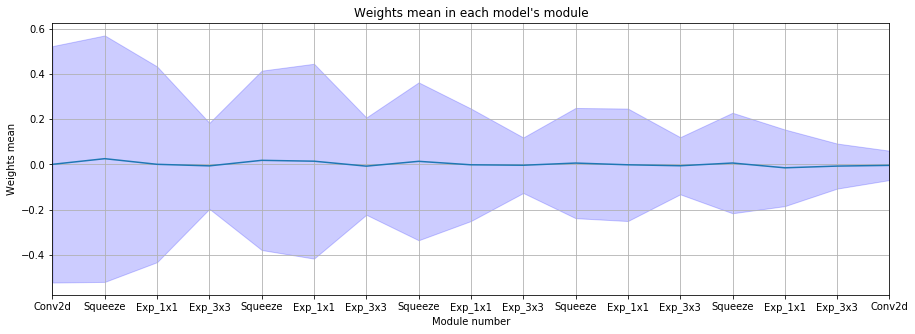

In [135]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(np.arange(1, len(means)+1), means)
plt.fill_between(np.arange(1, len(means)+1), (means-2*stds), (means+2*stds), color='b', alpha=.2)
plt.ylabel('Weights mean')
plt.title("Weights mean in each model's module")
plt.xlabel('Module number')
#plt.xticks(np.arange(1, 18))
plt.xlim([1, 17])
plt.xticks(np.arange(1, 18), module_name, rotation=0)
plt.show()